# Summary

The following code trains a LightGBM model on crash data from the years 2018 - 2019 and validates its performance using crash data from the year 2020.

#### Setup

In [7]:
import optuna as opt
import pandas as pd
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score

opt.logging.set_verbosity(opt.logging.WARNING) # Hides optuna trial spam output

pth = '../data/train_test_split_final'
train_data = pd.read_csv(f'{pth}/train.csv')
val_data = pd.read_csv(f'{pth}/validate.csv')
test_data = pd.read_csv(f'{pth}/test.csv')

cols = train_data.columns
in_cols = cols[:-4]
out_cols = cols[-4:]

X_train = train_data[in_cols]
y_train = train_data[out_cols].copy()
y_train[cols[-1]] = y_train[cols[-1]].round().astype(int)

X_val = val_data[in_cols]
y_val = val_data[out_cols].copy()
y_val[cols[-1]] = y_val[cols[-1]].round().astype(int)

X_test = test_data[in_cols]
y_test = test_data[out_cols].copy()
y_test[cols[-1]] = y_test[cols[-1]].round().astype(int)

def plot_loss(loss, ax=None, title=None, label=None):
    loss_series = pd.Series(loss)
    avg_loss = loss_series.rolling(window=20).mean()
    if ax is not None:
        ax.plot(avg_loss, label=label)
        ax.set_title(title)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('MSE')
        ax.legend()

def reg_obj(trial, X_train, X_val, y_train, y_val, target_col):
    reg_params = {
        'objective': 'regression',
        'metric': 'l2',
        'boosting': 'gbdt',
        'verbose': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-4, 8),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 0.9), 
        'n_iter': trial.suggest_int('n_iter', 50, 200), 
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 40),
        'max_depth': trial.suggest_int('max_depth', 2, 6), 
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 10),
        'random_state': 69,
        'force_row_wise': True
    }

    model = LGBMRegressor(**reg_params)
    model.fit(X_train, y_train[target_col])
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    train_mse = mean_squared_error(y_train[target_col], pred_train)
    val_mse = mean_squared_error(y_val[target_col], pred_val)

    attrs = {
        'reg_train': train_mse,
        'reg_val': val_mse,
    }

    for k, v in attrs.items():
        trial.set_user_attr(k, v)

    return val_mse # Target of minimization

# Could not use multi-class objective function due to class mismatch (model only saw 3 out of the 5 possible classes in training data set)
# Used regression function instead and rounded output to nearest integer
'''    
def multi_obj(trial, X_train, X_val, y_train, y_val, target_col):
    multi_params = {
        'objective': 'multiclass', 
        'metric': 'multi_logloss', 
        'boosting': 'gbdt',
        'verbosity': -1,
        'num_class': 5,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.9), 
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9), 
        'n_iter': trial.suggest_int('n_iter', 50, 200), 
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 30),
        'max_depth': trial.suggest_int('max_depth', 2, 6), 
        'num_leaves': trial.suggest_int('num_leaves', 25, 40),
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 10),
        'random_state': 69,
        'force_row_wise': True
    }

    model = LGBMClassifier(**multi_params)
    model.fit(X_train, y_train[target_col])
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    train_loss = log_loss(y_train[target_col], pred_train)
    val_loss = log_loss(y_val[target_col], pred_val)

    attrs = {
        'multi_train': train_loss,
        'multi_val': val_loss
    }

    for k, v in attrs.items():
        trial.set_user_attr(k, v)
    return val_loss
'''

def tune(obj, X_train, X_val, y_train, y_val, target_cols, n_trials=100):
    opt_params_dict = {}
    opt_models = {}
    opt_trials = {}
    train_errs = {}
    val_errs = {}
    for target in target_cols: # Iterate through all output columns
        study = opt.create_study(direction='minimize') # Minimize target variable
        #print(f"{target}:")
        study.optimize(lambda trial: obj(trial, X_train, X_val, y_train, y_val, target), n_trials=n_trials, show_progress_bar=False) # Set "show_progress_bar" to "True" to display trial run status bar
        opt_params = study.best_params # Optimal model parameters
        opt_params_dict[target] = opt_params
        
        opt_model = LGBMRegressor(**opt_params)
        opt_model.fit(X_train, y_train[target])
        opt_models[target] = opt_model
        opt_trials[target] = study.best_trial.number
    
        train_errs[target] = [t.user_attrs['reg_train'] for t in study.trials]
        val_errs[target] = [t.user_attrs['reg_val'] for t in study.trials]
    
    return opt_models, train_errs, val_errs, opt_params_dict, opt_trials
        

#### Training

In [8]:
reg_cols = out_cols[:3]
multi_col = out_cols[3]

trained_models, train_loss, val_loss, opt_params, opt_trials = tune(reg_obj, X_train, X_val, y_train, y_val, out_cols, n_trials=200)

#### Training and validation results

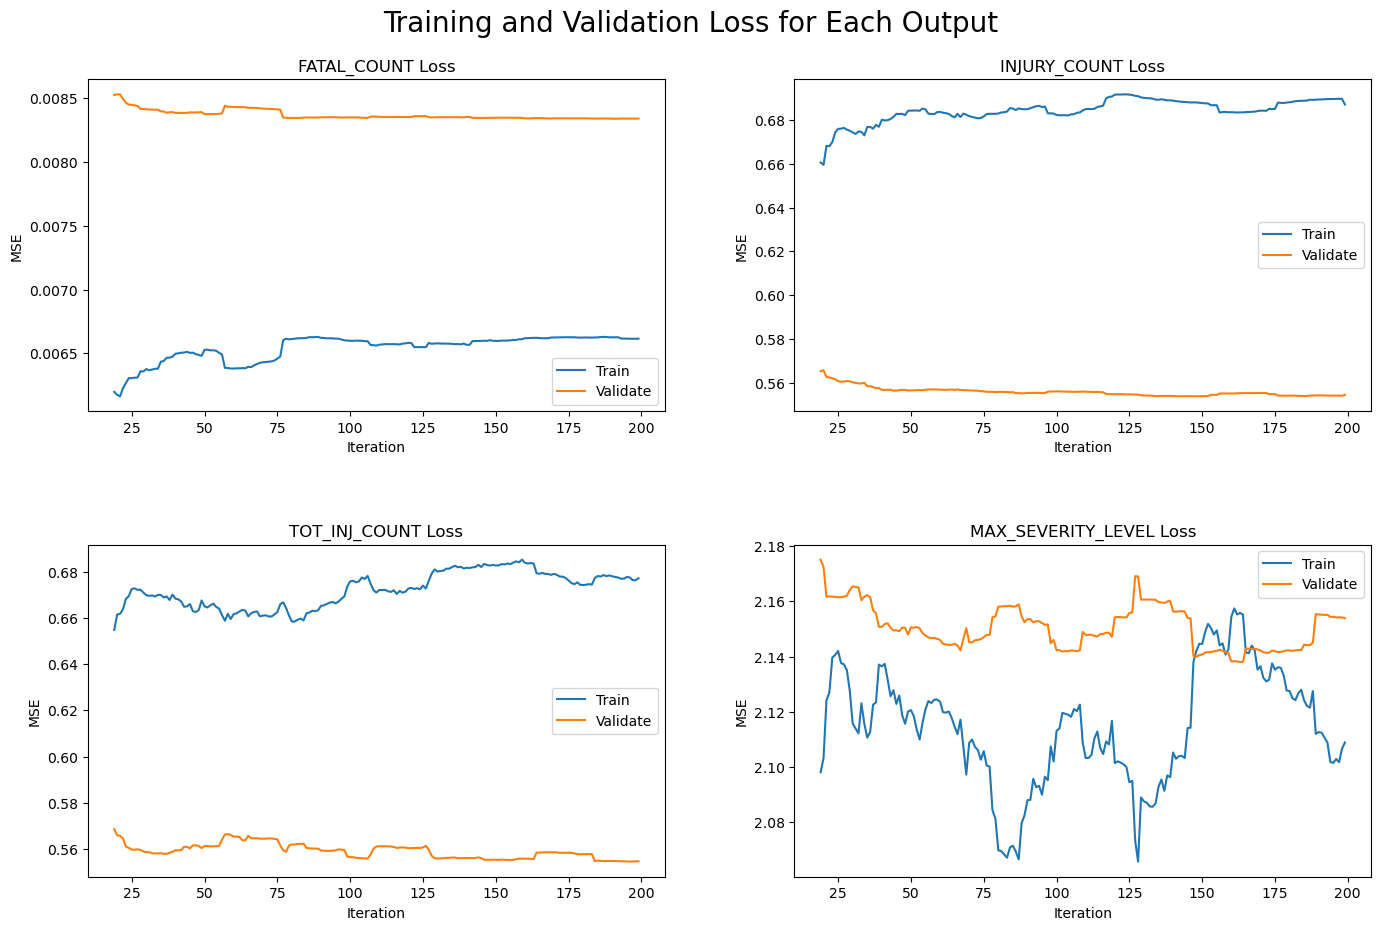

('FATAL_COUNT', {'learning_rate': 0.06689171016149278, 'lambda_l2': 0.12356319024080836, 'feature_fraction': 0.8001662999502557, 'bagging_fraction': 0.8518859278157754, 'n_iter': 63, 'min_data_in_leaf': 22, 'max_depth': 2, 'num_leaves': 23, 'bagging_freq': 8})
('INJURY_COUNT', {'learning_rate': 0.08496708130411162, 'lambda_l2': 7.300033574571911, 'feature_fraction': 0.6970243377375835, 'bagging_fraction': 0.5265137145316056, 'n_iter': 161, 'min_data_in_leaf': 36, 'max_depth': 2, 'num_leaves': 22, 'bagging_freq': 10})
('TOT_INJ_COUNT', {'learning_rate': 0.03553196751506497, 'lambda_l2': 2.320319025069272, 'feature_fraction': 0.6047013471381062, 'bagging_fraction': 0.5014776511346922, 'n_iter': 173, 'min_data_in_leaf': 25, 'max_depth': 4, 'num_leaves': 32, 'bagging_freq': 9})
('MAX_SEVERITY_LEVEL', {'learning_rate': 0.02930548245658153, 'lambda_l2': 4.3990922519864135, 'feature_fraction': 0.6747777353442925, 'bagging_fraction': 0.825529675347141, 'n_iter': 194, 'min_data_in_leaf': 21, 'm

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, target in zip(axs.ravel(), out_cols):
    tl = train_loss[target]
    vl = val_loss[target]
    plot_loss(tl, ax=ax, label='Train')
    plot_loss(vl, ax=ax, title=f'{target} Loss', label='Validate')

plt.tight_layout(pad=5)
plt.suptitle('Training and Validation Loss for Each Output', fontsize=20)
plt.show() 

for param in opt_params.items():
    print(param)

print("Column             |  Train MSE    |  Validation MSE")
print("-------------------|---------------|----------------")

for i, reg_col in enumerate(reg_cols):
    t = opt_trials[reg_col]
    print(f"{reg_col}\t   |  {train_loss[reg_col][t]:.3f}\t   |  {val_loss[reg_col][t]:.3f}")
print(f"{multi_col} |  {train_loss[multi_col][opt_trials[multi_col]]:.3f}\t   |  {val_loss[multi_col][opt_trials[multi_col]]:.3f}")

*Note: The MSE calculation for the* `MAX_SEVERITY_LEVEL` *output column is technically invalid, as it is a classification task. However, a higher MSE is expected for this column compared to the other three regression output columns, since a regression model was used to predict all outputs.*

#### Save model to a .txt file

In [10]:
from save_load_model import save_lgb_model
import json

# Uncomment to save best models to .txt file and convert and save best models to .json
'''
for col in reg_cols:
    trained_model = trained_models[col]
    save_lgb_model(trained_model, f'{col}_model', '../final_outputs')
    with open(f'../final_outputs/{col}_model_params.json', 'w') as model  _json:
        json.dump(trained_model.get_params(), model_json, indent=2)
'''

"\nfor col in reg_cols:\n    trained_model = trained_models[col]\n    save_lgb_model(trained_model, f'{col}_model', '../final_outputs')\n    with open(f'../final_outputs/{col}_model_params.json', 'w') as model  _json:\n        json.dump(trained_model.get_params(), model_json, indent=2)\n"